## Downgrade tensorflow version to match Teachable Machine Training

In [ ]:
!pip install tensorflow==2.12

## Check GPUs available

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpu = 0
tf.config.experimental.set_memory_growth(gpu, True)

## Function to classify image

In [13]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
# model_path = '../input/keras-test/tensorflow2/teste/1/keras_model.h5'
model_path = '../input/keras-test/tensorflow2/150-epochs-1/1/keras_model.h5'
model = load_model(model_path, compile=False)

# Load the labels
# class_names = open("labels.txt", "r").readlines()
# class_names = ['0 Com acumulo Significativo de Ã\xa0gua - 1\n',
#  '1 Sem acumulo de Ã\xa0gua - 0\n']

def classify_image(image_path):
    class_names = ['0 0', '1 1']

    # Create the array of the right shape to feed into the keras model
    # The 'length' or number of images you can put into the array is
    # determined by the first position in the shape tuple, in this case 1
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    # Replace this with the path to your image
    image = Image.open(image_path).convert("RGB")

    # resizing the image to be at least 224x224 and then cropping from the center
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # turn the image into a numpy array
    image_array = np.asarray(image)

    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the image into the array
    data[0] = normalized_image_array

    # Predicts the model
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]
    
    return {'label': int(class_name[2:]), 'prob': confidence_score}

image_path = "/kaggle/input/flood-balanced-10/balanced-10/test/0/CODE1138 2023-02-07 21-30-03-6.jpg"

classify_image(image_path)

1/1 [==============================] - 1s 880ms/step


{'label': 1, 'prob': 0.9937103}

In [14]:
from time import time
from IPython.display import clear_output as co

class Progress:
    def __init__(self, total):

        self.total = total
        self.i = -1
        self.start = time()
        self.display()

    def display(self):
        self.i += 1

        done = self.i
        progress = done / self.total * 100
        left = self.total - done
        seconds = time() - self.start
        fps = done / max(seconds, 1e-6)
        minutes = seconds // 60
        seconds = seconds % 60

        minutes = int(minutes)
        progress = int(progress)
        fps = round(fps, 2)
        seconds = round(seconds, 1)

        bar_size = 40
        bar_done = bar_size * done / self.total
        bar_done = int(bar_done)
        bar_left = bar_size - bar_done

        text = f'|{"█" * bar_done}{" " * bar_left}| {done}/{self.total} [{progress}%] in {minutes}:{seconds} ({fps}/s)'
        co(True)
        print(text)

# Example usage
from time import sleep
total = 5
p = Progress(total)
for i in range(total):
    sleep(1)
    p.display()
    
import pandas as pd
from sklearn.metrics import classification_report as cr

def custom_cr(y_true, y_hat):
    stats = cr(y_true, y_hat, output_dict=True, zero_division=0)
    return {
        'accuracy': stats['accuracy'],
        'recall_0': stats['0']['recall'],
        'recall_1': stats['1']['recall'],
        'precision_0': stats['0']['precision'],
        'precision_1': stats['1']['precision'],
    }

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def group_classification_report(y_true, y_hat, codes, sort_by='accuracy', name='TEST', figsize=(4, 8)):

    # Classification report
    print(f'\nClassification Report ({name}):\n')
    print(cr(y_true, y_hat))

    # Classification report per camera
    stats = []
    for code in codes.unique():
        msk = codes == code
        stat = custom_cr(y_true[msk], y_hat[msk])
        stats.append({'code':code, **stat})
    stats = pd.DataFrame(stats)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(stats.set_index('code').sort_values(sort_by, ascending=False), annot=True)
    ax = ax.set(title=f"{name}")
    return

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def precision_recall_curve_plot(y_true, probs, title="Precision-Recall Curve"):

    precision, recall, thresholds = precision_recall_curve(y_true, probs, pos_label=1)

    plt.plot(thresholds, precision[:-1])
    plt.plot(thresholds, recall[:-1])
    plt.title(title)
    plt.legend(['Precision', 'Recall'])
    plt.xlabel('Confidence')
    return plt.show()

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def subsample_accuracy_plot(y_true, y_pred, n_samples=500, n_images=250):
    sizes = list(range(1, len(y_true) + 1))
    accs = [accuracy_score(y_true.sample(i, random_state=i), y_pred.sample(i, random_state=i)) for i in sizes]

    plt.figure(figsize=(5, 3.5))
    plt.plot(sizes, accs)
    plt.title('Accuracy vs Sample Size')
    plt.show()

    sizes = range(n_samples)
    accs = [accuracy_score(y_true.sample(n_images, random_state=i), y_pred.sample(n_images, random_state=i)) for i in sizes]

    plt.figure(figsize=(5, 3.5))
    plt.plot(sizes, accs)
    plt.title(f'Accuracy vs Random Samples ({n_images} samples x {n_samples} times)')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.hist(accs)
    plt.title(f'Accuracy Frequency ({n_images} samples x {n_samples} times)')
    plt.show()
    
    

|████████████████████████████████████████| 5/5 [100%] in 0:5.0 (1.0/s)


## Load dataframe with paths to images

In [15]:
import pandas as pd

dataset_folder = '/kaggle/input/flood-balanced-10/balanced-10'

df = pd.read_csv(f'{dataset_folder}/images.csv', index_col=0)
df['true_path'] = [f"{dataset_folder}/{row['set']}/{row['flood']}/{row['file_name']}" for idx, row in df.iterrows()]

import os
exists = [os.path.exists(path) for path in df['true_path']]

display(df.head(1))
print('  * All paths exist:', all(exists))

,id_video,code,folder,file_name,file_path,frame_index,timestamp,initial_timestamp,seen,tags,tag,flood,set,true_path
238754,650e811b9ba69cc1a141687d,1474.0,polygons/flood-probability/1/1474/CODE1474 202...,CODE1474 2023-08-20 13-30-37-3.jpg,polygons/flood-probability/1/1474/CODE1474 202...,31,2023-08-20 13:30:37.3,2023-08-20 13:30:27,True,[],normal,0,train,/kaggle/input/flood-balanced-10/balanced-10/tr...


  * All paths exist: True


## Remove previous results

In [6]:
# !rm /kaggle/working/models/pred_val.json

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Classify images progressively

In [16]:
import os
import json

rs = 12345
pred_path = f'/kaggle/working/models/pred_val_150.json'
data = df[df['set'] == 'val'].copy()

# Shuffle data
df_random = data.sample(len(data), random_state=rs)

# Create folder path
pred_folder = os.path.dirname(pred_path)
if not os.path.exists(pred_folder):
    os.makedirs(pred_folder)
    
# Load existing results
try:
    results = json.load(open(pred_path, 'r'))
except FileNotFoundError:
    results = []

# Start tracking progress
left = len(data) - len(results)
p = Progress(left)

for i, (idx, row) in enumerate(df_random.iterrows()):
    # Only process the next file in the queue
    if i == len(results):
        # Get the image path
        image_path = row['true_path']

        # Classify the image
        data = classify_image(image_path)

        # Extract the result
        label = data['label']
        prob = float(data['prob'])
        result = {'index': idx, 'label': label, 'prob': prob}

        # Store the result
        results.append(result)

        # Save the result progressively
        with open(pred_path, 'w') as fw:
            fw.write(json.dumps(results))

        # Display progress
        p.display()


|████████████████████████████████████████| 1427/1427 [100%] in 2:9.9 (10.99/s)


## Reload and format results

In [17]:
import json
import pandas as pd

# pred_path = f'/kaggle/working/models/pred_val.json'
pred_path = f'/kaggle/working/models/pred_val_150.json'

pred = json.load(open(pred_path, 'r'))
pred = pd.DataFrame(pred).set_index('index')
pred['code'] = df['code'].loc[pred.index]

# Process result
pred['label'] = pred['label'].astype(int)

# Get true and predicted labels
y_true = df['flood'].loc[pred.index].copy()
y_pred = pred['label'].copy()

# Invert labels
# msk_1 = y_pred == 1
# msk_0 = y_pred == 0
# y_pred[msk_0] = 1
# y_pred[msk_1] = 0

display(pred.head())

,label,prob,code
index,,,
318471,0,0.999746,1475.0
58221,1,0.999971,367.0
341340,0,1.000000,1119.0
276448,1,0.999999,1475.0
38996,0,0.832468,1018.0


## Confusion Matrix

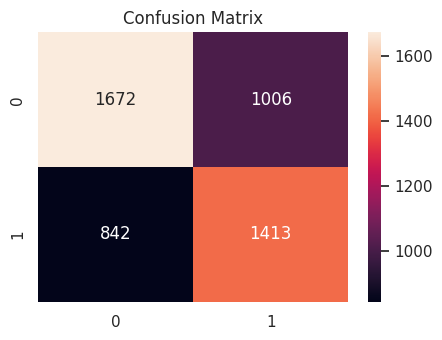

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as CM

cm = CM(y_true, y_pred)
plt.figure(figsize=(5, 3.5))
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt="")

## Classification Metrics


Classification Report (TEST SET):

              precision    recall  f1-score   support

           0       0.67      0.62      0.64      2678
           1       0.58      0.63      0.60      2255

    accuracy                           0.63      4933
   macro avg       0.62      0.63      0.62      4933
weighted avg       0.63      0.63      0.63      4933



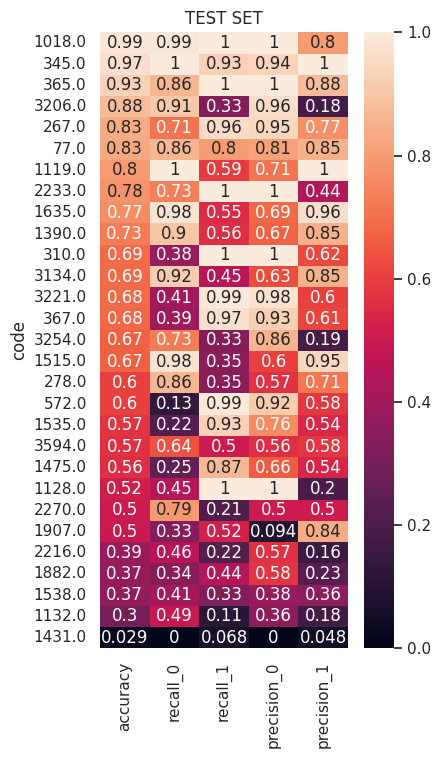

In [21]:
codes = pred['code']

group_classification_report(y_true, y_pred, codes, sort_by='accuracy', name='TEST SET', figsize=(4, 8))

## Subsample evaluation

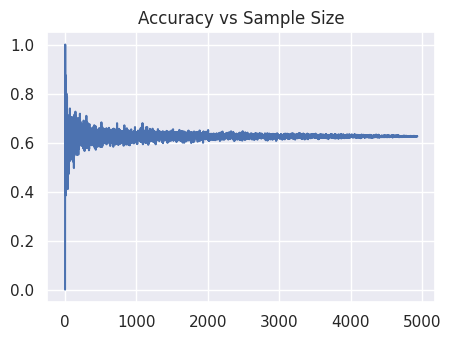

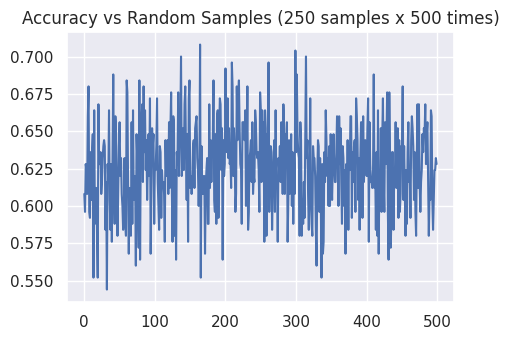

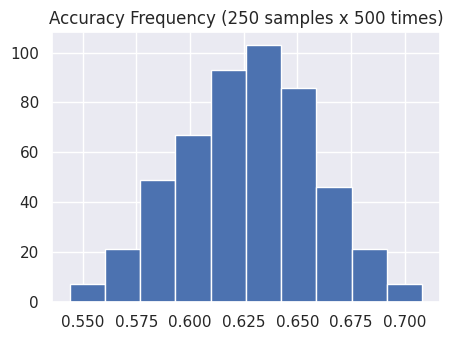

In [19]:
subsample_accuracy_plot(y_true, y_pred, n_samples=500, n_images=250)